## Import Packages

In [189]:
import os
from math import pi

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scipy import spatial

from labvision import images, video
import filehandling
from particletracking import dataframes, statistics

from matplotlib import path

from shapely.geometry import LineString

## Get the first frame from each video

In [2]:
main_directory = filehandling.open_directory()
frame_directory = f"{main_directory}/first_frames"

In [3]:
def get_crop_and_mask(im):
    if not os.path.isfile(f"{main_directory}/crop.txt"):
        crop_result = images.crop_polygon(im)
        crop = np.array(crop_result.bbox.to_tuple())
        mask = np.array(crop_result.mask)
        np.savetxt(f"{main_directory}/crop.txt", crop)
        np.savetxt(f"{main_directory}/mask.txt", mask)
    else:
        crop = np.loadtxt(f"{main_directory}/crop.txt", dtype=np.uint16)
        crop = images.BBox(crop[0, 0], crop[1, 0], crop[0, 1], crop[1, 1])
        mask = np.loadtxt(f"{main_directory}/mask.txt", dtype=np.uint8)
    return crop, mask

In [4]:
def create_single_frames(main_directory, frame_directory):
    if os.path.isdir(frame_directory):
        print("Directory exists")
    else:
        os.mkdir(frame_directory)

    vid_files = filehandling.get_directory_filenames(f"{main_directory}/*.MP4")
    frame_files = filehandling.get_directory_filenames(f"{frame_directory}/*.png")

    if len(frame_files) < len(vid_files):
        for vid_file in vid_files:
            direc, vid_file = os.path.split(vid_file)
            vid_name, _ = os.path.splitext(vid_file)
            if os.path.isfile(f"{frame_directory}/{vid_name}.png"):
                print(f"{vid_name}.png already exists")
            else:
                vid = video.ReadVideo(f"{direc}/{vid_file}")
                frame = vid.read_next_frame()
                crop, mask = get_crop_and_mask(frame)
                frame = images.crop_and_mask(frame, crop, mask)
                images.save(frame, f"{frame_directory}/{vid_name}.png")

In [6]:
create_single_frames(main_directory, frame_directory)

Directory exists


## Find Circles in each image

In [7]:
def get_images(frame_directory):
    image_files = filehandling.get_directory_filenames(f"{frame_directory}/*.png")
    ims = [images.load(f) for f in image_files]
    return ims
ims = get_images(frame_directory)

In [8]:
%matplotlib auto
def find_circles(ims):
    gray = [images.bgr_to_gray(im.copy()) for im in ims]
    circles = [images.find_circles(g, 45, 200, 7, 33, 33) 
               for g in gray]
    return circles

def create_data(dataname, ims, force_new=False):
    if os.path.isfile(dataname):
        data = dataframes.DataStore(dataname)
    else:
        data = dataframes.DataStore(dataname, load=False)
        circles = find_circles(ims)
        for f, info in tqdm(enumerate(circles), 'Adding Circles'):
            data.add_tracking_data(f, info, ['x', 'y', 'r'])

        calc = statistics.PropertyCalculator(data)
        calc.order()
        data.save()
    return data

data = create_data(f"{frame_directory}/first_frame_data.hdf5", ims)

Using matplotlib backend: Qt5Agg



[########################################] | 100% Completed |  0.3s


In [10]:
plt.imshow(ims[0])
plt.plot(data.df.loc[0].x, data.df.loc[0].y, 'o')

## Get Radius

In [11]:
RADIUS = data.df.loc[0].r.mean()
RADIUS

34.30095

## Calculate Fields

In [508]:
def coarse_order_field(df, cgw, x, y, no_of_neighbours=20):
    """
    Calculate the coarse-grained field characterising local orientation order
    """

    order = df.order.values

    # Generate the lattice nodes to query
    # x, y = np.meshgrid(x, y)
    r = np.dstack((x, y))

    # Get the positions of all the particles
    particles = df[['x', 'y']].values

    # Generate the tree from the particles
    tree = spatial.cKDTree(particles)

    # Query the tree at all the lattice nodes to find the nearest n particles
    # Set n_jobs=-1 to use all cores
    dists, indices = tree.query(r, no_of_neighbours, n_jobs=-1)

    # Calculate all the coarse-grained delta functions (Katira ArXiv eqn 3
    cg_deltas = np.exp(-dists ** 2 / (2 * cgw ** 2)) / (2 * pi * cgw ** 2)

    # Multiply by the orders to get the summands
    summands = cg_deltas * order[indices]

    # Sum along axis 2 to calculate the field
    field = np.sum(summands, axis=2)

    return field

def calculate_fields(data, cgw, x, y, N=None):
    if N is None:
        N = len(ims)
    return [coarse_order_field(data.df.loc[f], cgw, x, y)
           for f in tqdm(range(N), 'Calculating Fields')]

In [517]:
lattice_spacing = 1
x = np.arange(0, ims[0].shape[1], lattice_spacing)
y = np.arange(0, ims[0].shape[0], lattice_spacing)
x, y = np.meshgrid(x, y)

In [518]:
cgw = RADIUS * 4

In [519]:
fields = calculate_fields(data, cgw, x, y)

In [520]:
plt.imshow(fields[0])

## Find the field threshold from between histogram peaks

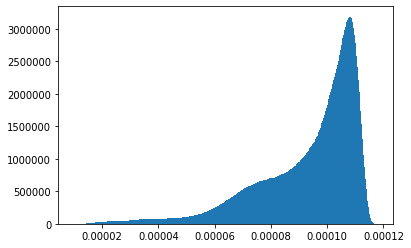

In [521]:
%matplotlib inline
_ = plt.hist(np.ndarray.flatten(np.stack(fields)), bins=1000)

In [522]:
field_threshold = 9.0e-5

In [536]:
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(fields[0] < 7e-5)
plt.subplot(2, 2, 2)
plt.imshow(fields[0] < 8e-5)
plt.subplot(2, 2, 3)
plt.imshow(fields[0] < 9e-5)
plt.subplot(2, 2, 4)
plt.imshow(fields[0] < 10e-5)

## Threshold all the images then find contours

In [114]:
def get_contour(f, t):
    im = np.uint8(f < t)
    im = imfill(im)
    cs = images.find_contours(im)
    cs = images.sort_contours(cs)
    return cs[-1]

def get_contours(fields, t):
    return [get_contour(f, t) for f in fields]

In [523]:
contours = get_contours(fields, field_threshold)

In [120]:
def find_white_edge_pixel(im):
    h, w = im.shape
    row = im[0, :]
    idx = np.nonzero(row)[0]
    if len(idx) > 0:
        return idx[0], 0
    row = im[h-1, :]
    idx = np.nonzero(row)[0]
    if len(idx) > 0:
        return idx[0], h-1
    col = im[:, 0]
    idx = np.nonzero(col)[0]
    if len(idx) > 0:
        return 0, idx[0]
    col = im[:, w-1]
    idx = np.nonzero(col)[0]
    if len(idx) > 0:
        return w-1, idx[0]
    return None

In [119]:
def imfill(im):
    
    point = find_white_edge_pixel(im)
    if point is None:
        return im
    else:
        h, w = im.shape
        im_floodfill = im.copy()
        mask = np.zeros((h+2, w+2), np.uint8)

        # Floodfill from point
        cv2.floodFill(im_floodfill, mask, point, 0)
    #     plt.imshow(im_floodfill)

        # Invert floodfilled image
        im_floodfill_inv = cv2.bitwise_not(im_floodfill)

        # Combine the two images
        im_out = cv2.bitwise_and(im, im_floodfill)

        im = imfill(im_out)
    
    return im    

### Close all the contours

In [524]:
def close_contour(c):
    return np.concatenate((c, c[[0], :, :]))

contours = [close_contour(c) for c in contours]

### Multiply contours by the lattice spacing

In [525]:
contours = [c*lattice_spacing for c in contours]

## Select the centre of the intruder

In [121]:
center = images.crop_circle(ims[37][500:1500, 1000:2000]).bbox

In [122]:
center = np.mean((center.xmin, center.xmax))+1000, np.mean((center.ymin, center.ymax))+500

In [123]:
center

(1459.5, 1086.5)

## Remove contours that don't contain the center

In [526]:
def contour_contains_center(contour, center):
    contour_path = path.Path(contour.squeeze())
    return contour_path.contains_points([center])[0]
contours, used_indexes = zip(*[[c, i] for i, c in enumerate(contours) if contour_contains_center(c, center)])

### Select the angles to rotate by

In [473]:
N = 200
angles = np.arange(0, 2*pi, 2*pi/N)

In [527]:
def get_heights(contour, center, angles):
    heights = []
    all_intersections = []
    c = LineString(contour.squeeze())
    for a in angles:
        p1 = (center[0]+2000*np.cos(a), center[1]+2000*np.sin(a))
        line = LineString([[center[0], center[1]], [p1[0], p1[1]]])
        intersections = line.intersection(c)
        
        if intersections.geom_type == 'Point':
            x, y = intersections.xy           
            x, y = x[0], y[0]
            
        elif intersections.geom_type == 'MultiPoint':
            x, y = intersections[0].xy
            last_dist = 1000000
            for p in intersections:
                xi, yi = p.xy
                dist = np.sqrt((xi-center[0])**2+(yi-center[1])**2)
                if dist < last_dist:
                    x, y = xi, yi
                    x, y = x[0], y[0]
        else:
            print(intersections)
        
        
        dist = np.sqrt((x-center[0])**2+(y-center[1])**2)
        all_intersections.append((x, y))
        heights.append(dist)
    return heights, all_intersections
        

        
        
heights, interfaces = zip(*[get_heights(c, center, angles) for c in tqdm(contours)])

GEOMETRYCOLLECTION (POINT (1103 1443), POINT (1105.5 1440.5), LINESTRING (1109 1437, 1107 1439))
LINESTRING (1791 1418, 1792 1419)



## Check interfaces

In [528]:
%matplotlib auto
fig, ax = plt.subplots()
ax.imshow(ims[used_indexes[10]])
i = np.array(interfaces[10])
ax.plot(i[:, 0], i[:, 1])

Using matplotlib backend: Qt5Agg


In [529]:
interface_radius = np.mean(np.array(heights))
interface_radius

635.0333775516577

## Fourier Transform

In [564]:
def get_plot_values(heights, dL, L):
    fourier = [np.abs(np.fft.fft(h))**2 for h in heights]
    y = np.stack(fourier)[:, 1:N//2] * L
    
    freq = np.fft.fftfreq(N, dL)[1:N//2]
    
    y_mean = np.mean(y, axis=0).squeeze()
    y_err = np.std(y, axis=0, ddof=1).squeeze()
    
    x = freq * 2 * np.pi
    
    xplot = np.log10(x)
    yplot = np.log10(y_mean)
    yerr = 0.434 * y_err / y_mean
    return xplot, yplot, yerr

def get_fit(x, y, dy):
    fit, fit_err = np.polyfit(x, y, 1, w=1/(dy*dy), cov=True)
    return fit, np.sqrt(np.diag(fit_err))
    

def plot_fft(heights, R, mmin, mmax, ax=None, plot=True):
    m = np.arange(mmin, mmax+1, 1)
    k = m / R
    
    R_k_squared_i = [np.abs(np.fft.rfft(h)**2) for h in heights]
    R_k_squared = np.mean(R_k_squared_i, axis=0)
    R_k_squared_std = np.std(R_k_squared_i, ddof=1, axis=0)

    x = np.log10(k)
    y = np.log10(R_k_squared[mmin:mmax+1]*2*pi*R)
    dy = (0.434 * R_k_squared_std / R_k_squared)[mmin:mmax+1]
    
    fit, fit_err = get_fit(x, y, dy)
    
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        ax.errorbar(x, y, yerr=dy, label='Data')
        ax.plot(x, fit[0]*x + fit[1], label=f"Fit (gradient = {fit[0]:.2f}+/-{fit_err[0]:.2f}))")
        ax.set_xlabel('log$_{10}(k = 2\pi m/L)$ [pix$^{-1}$]')
        ax.set_ylabel('log$_{10}(<|\delta h_k|^2>L)$ [pix$^3$]')
        ax.legend()
    return fit[0]

In [530]:
kmax = 2*pi/cgw
mmax = kmax*interface_radius
mmax = int(mmax)

In [531]:
fit = plot_fft(heights, interface_radius, 5, mmax)

In [533]:
mmins = np.arange(1, 20, 1)
fits = [plot_fft(heights, interface_radius, mmin, mmax, plot=False) for mmin in mmins]
plt.title('The difference in gradient for different lower bounds of the fit')
plt.xlabel('Lower bound m')
plt.ylabel('Fit')
plt.plot(mmins, fits)

In [489]:
def get_fit_vs_N(N):
    angles = np.arange(0, 2*pi, 2*pi/N)
    heights, interfaces = zip(*[get_heights(c, center, angles) for c in tqdm(contours)])
    interface_radius = np.mean(np.array(heights))
    fit = plot_fft(heights, interface_radius, 1, 20, plot=False)
    return fit

Ns = np.arange(40, 400, 10)

fits = list(map(get_fit_vs_N, Ns))

KeyboardInterrupt: 

## Calculate the fields 

In [538]:
lattice_spacing = 10
x = np.arange(0, ims[0].shape[1], lattice_spacing)
y = np.arange(0, ims[0].shape[0], lattice_spacing)
x, y = np.meshgrid(x, y)

In [539]:
fields = calculate_fields(data, cgw, x, y)

### Show a field

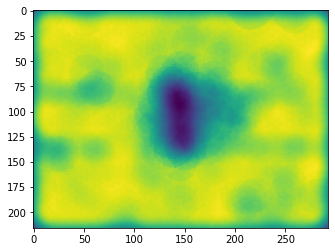

In [541]:
plt.imshow(fields[0])

## Plot the histogram to find the threshold

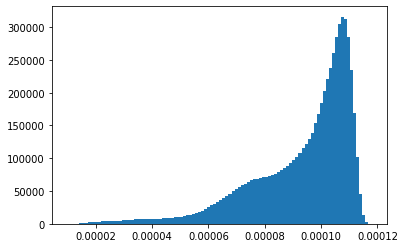

In [545]:
_ = plt.hist(np.ndarray.flatten(np.array(fields)), bins=100)

Peaks at 7.5e-5 and 11e-5 so chose threshold between these at 9

In [551]:
field_threshold = 9e-5

## Find the contours corresponding to the interface

In [553]:
contours = get_contours(fields, field_threshold)

## Multiply by the lattice constant and close the contours

In [554]:
contours = [c*lattice_spacing for c in contours]
contours = [close_contour(c) for c in contours]

## Remove contours that don't contain the center

In [555]:
contours, used_indexes = zip(*[[c, i] for i, c in enumerate(contours) if contour_contains_center(c, center)])

## Find the heights at different angles

In [556]:
N = 200
angles = np.arange(0, 2*pi, 2*pi/N)
heights, interfaces = zip(*[get_heights(c, center, angles) for c in tqdm(contours)])

## Plot an example interface
This isn't perfect

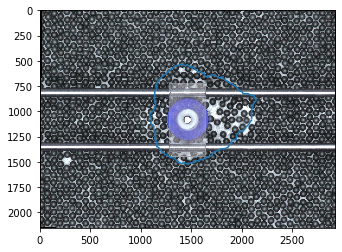

In [567]:
plt.figure()
plt.imshow(ims[used_indexes[0]])
i = np.array(interfaces[0])
plt.plot(i[:, 0], i[:, 1])

## Find the average radius of the interface

In [557]:
interface_radius = np.mean(np.array(heights))
interface_radius

629.7396703786761

## Find the maximum mode

In [561]:
mmax = int(2*pi*cgw / RADIUS)
mmax

25

## Plot the fourier transform between m=5 and m=25

-2.789359834507566

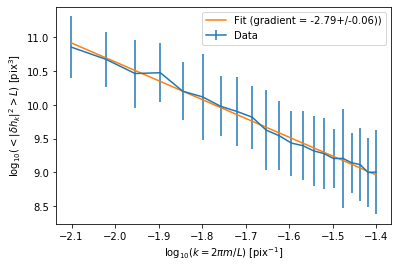

In [565]:
plot_fft(heights, interface_radius, 5, mmax)

## The fit changes when changing the minimum mode

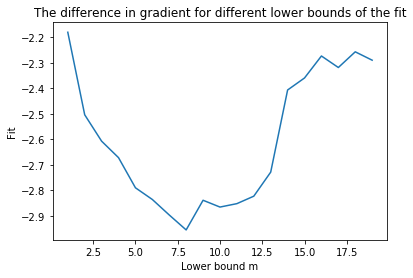

In [566]:
mmins = np.arange(1, 20, 1)
fits = [plot_fft(heights, interface_radius, mmin, mmax, plot=False) for mmin in mmins]
plt.title('The difference in gradient for different lower bounds of the fit')
plt.xlabel('Lower bound m')
plt.ylabel('Fit')
plt.plot(mmins, fits)